<a href="https://colab.research.google.com/github/dav1n9/DAP/blob/main/divorce_prediction_dash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dashboard

[참고1](https://plotly.com/python/pie-charts/)
[참고2](https://plotly.com/python/tick-formatting/)
[참고3](https://dash.plotly.com/layout)

divorce_prediction을 진행하면서 시각화했던 그래프들로 간단한 대시보드를 만들었습니다.

1. 그래프 정보

  3개의 탭으로 구분하였고, 각 탭에서 아래의 정보를 담은 그래프를 볼 수 있습니다.

      *  (1) 54개의 대답에 대한 **두 그룹의 대답 분포** -> 바그래프
      *  (2) **가장 많이 사용된 주요 단어** (0개~20까지) -> 라인그래프
      *  (3) **대답 유형별 비율** -> 파이차트


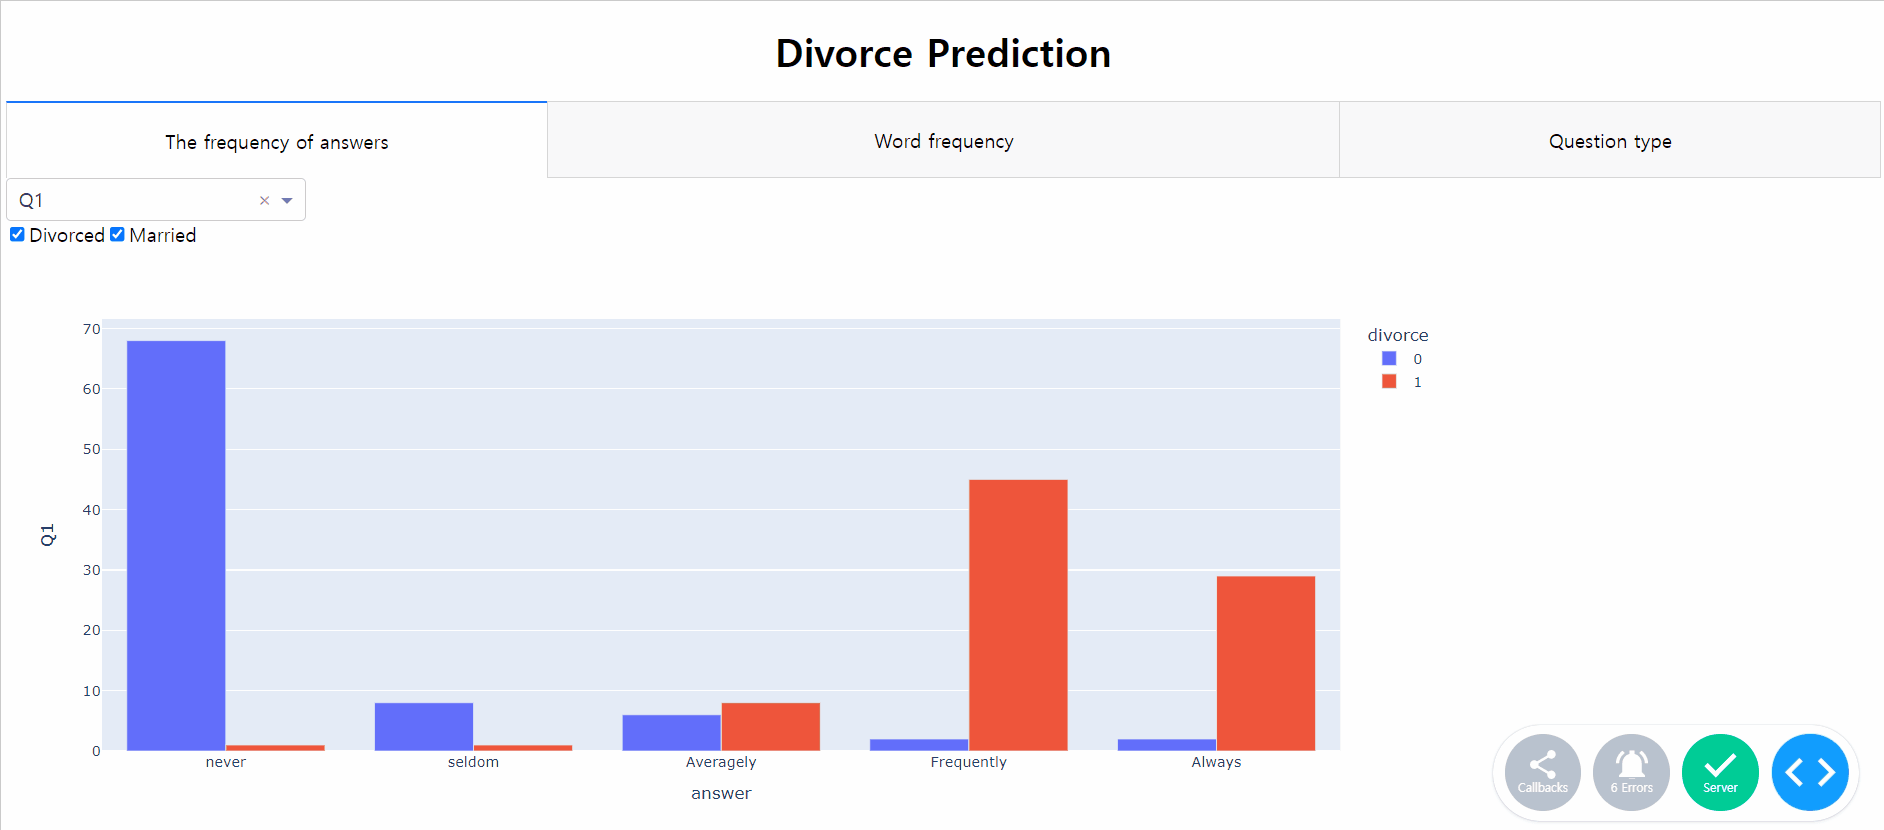



2. input values

  * 첫번째 바 그래프 : Dropdown으로 **질문선택**과 checkbox로 **그룹 선택**이 가능합니다.

  * 두번째 라인 그래프 : 사용빈도를 확인할 **단어 수를 입력**할 수 있습니다.(0부터 20까지의 숫자를 입력)

  * 세번째 파이차트 : Dropdown으로 원하는 **질문 타입을 선택**할 수 있고, 복수 선택이 가능합니다.


(1) 첫번째 탭 - 바그래프

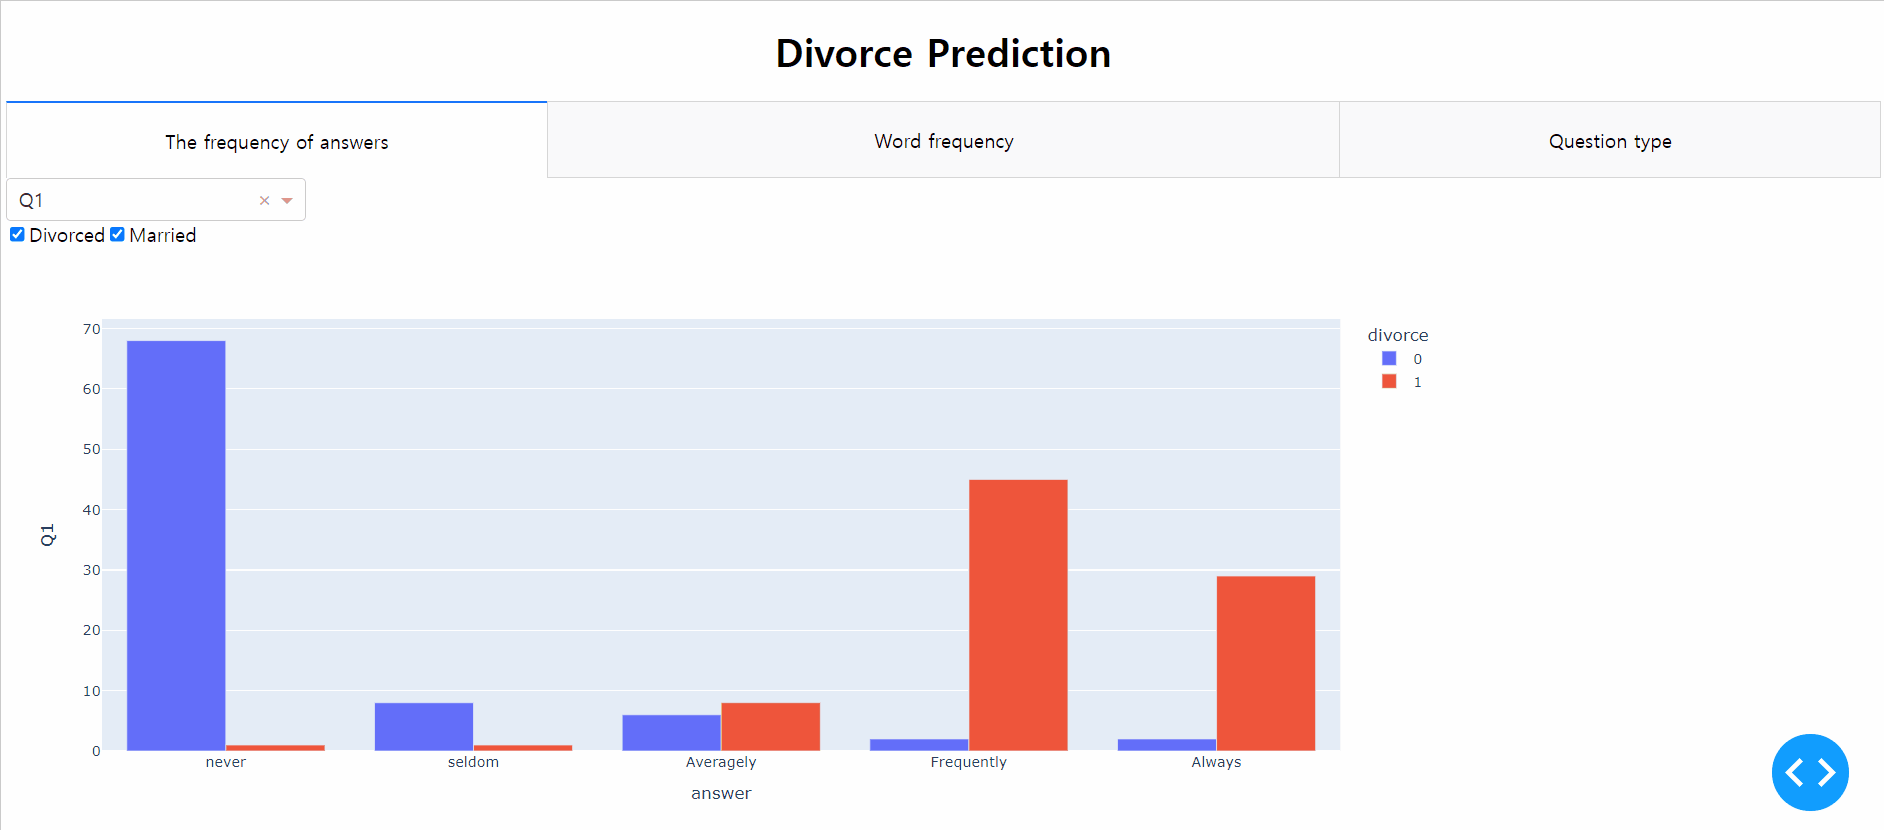

(2) 두번째 탭 - 라인그래프

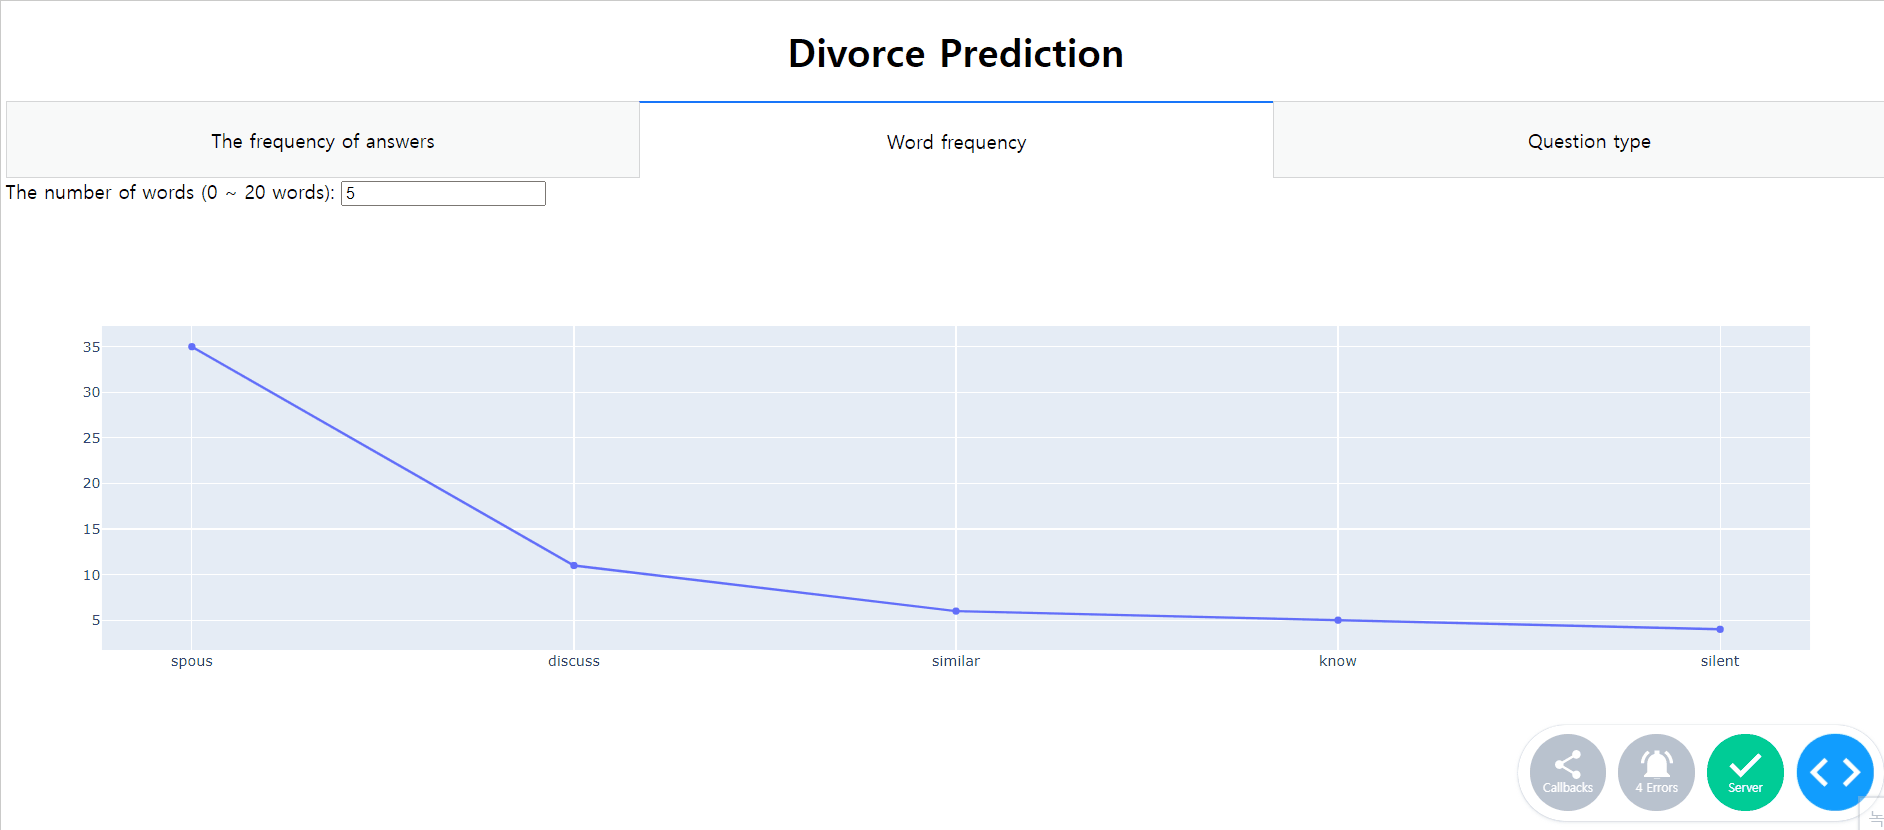

(3) 세번째 탭 - 파이차트

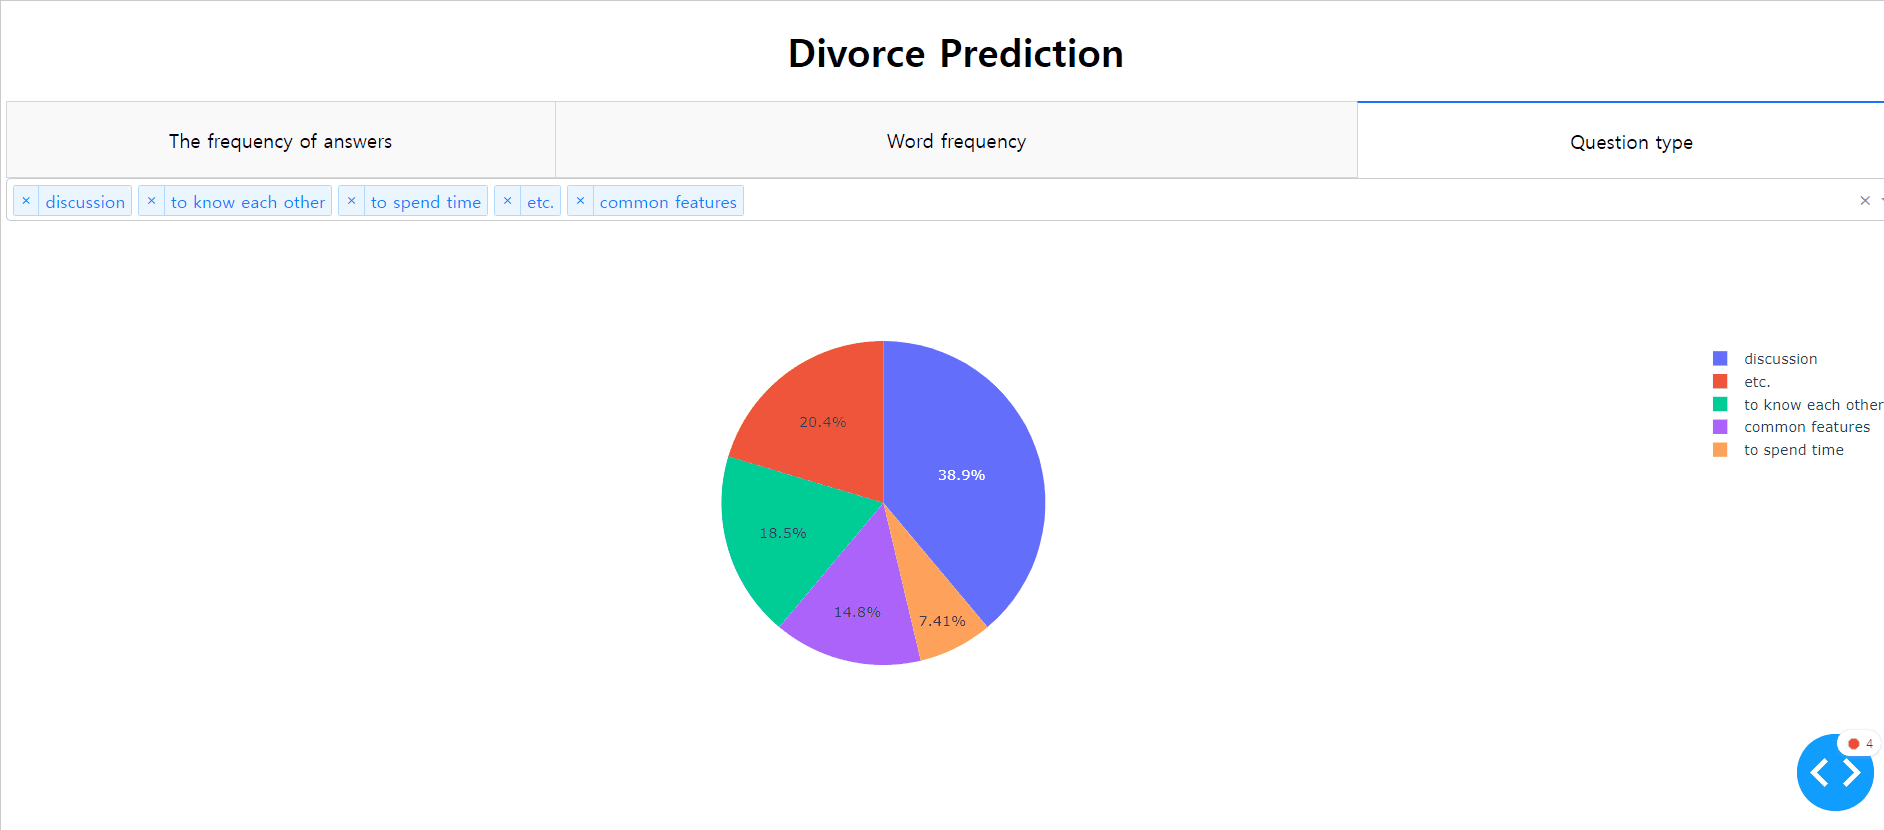

In [ ]:
!pip install dash
!pip install jupyter_dash

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# divorce.ipynb에서 생성한 데이터프레임을 따로 저장해두고, 불러옴

path_divorce = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/divorce_sum.csv'
df_sum = pd.read_csv(path_divorce,delimiter = ',')

path_reference = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/reference.tsv'
df_reference = pd.read_csv(path_reference, sep = "|", engine='python')


path_df_type = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/df_type.csv'
df_type = pd.read_csv(path_df_type, sep = ",", engine='python')

path_df_words_count = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/df_words_count.csv'
df_words_count = pd.read_csv(path_df_words_count, sep = ",", engine='python')

df_sum.set_index('answer', inplace = True)    #answer 열을 인덱스로 바꿔줌
df_sum['divorce'] = df_sum['divorce'].astype(str)     # str타입으로 바꿔준이유는 전에도 써있지만, 색을 0과1 2개로만 구분하기 위함.

data_divorced = df_sum.groupby('divorce').get_group('0')
data_married = df_sum.groupby('divorce').get_group('1')

In [3]:
df_type['labels'] = ['discussion', 'to know each other', 'to spend time', 'common features', 'etc.']

In [7]:
import dash
from dash import html
import plotly.graph_objects as go
from dash import dcc
import plotly.express as px
from dash.dependencies import Input, Output

from jupyter_dash import JupyterDash


# Load Dash App
app = JupyterDash()


app.layout = html.Div([html.H1("Divorce Prediction", style={'text-align' : 'center'}),
    dcc.Tabs([
              dcc.Tab(label='The frequency of answers', children=[
                                                                  dcc.Dropdown(id="dropdown",
                                                                               options = [{'label': i, 'value': i} for i in df_sum.columns],
                                                                               multi=False,
                                                                               value="Q1",
                                                                               style={'width': "40%"}
                                                                               ),
                                                                  dcc.Checklist(id="checkboxes",
                                                                                options=[{'label': 'Divorced', 'value': 'divorced'},
                                                                                         {'label': 'Married', 'value': 'married'}], 
                                                                                value=['divorced', 'married']),
                                                                  dcc.Graph(id='bar', figure={})
                                                                  ]),
              # 두번째 탭
              dcc.Tab(label='Word frequency', children=[
                                                        html.Label('The number of words (0 ~ 20 words): '),
                                                        dcc.Input(id="num_words", value=5, type='number'),
                                                        dcc.Graph(id="fre_words")
                                                        ],style={'width': '49%', 'display': 'inline-block'}),
              # 세번째 탭
              dcc.Tab(label='Question type', children=[
                                                       dcc.Dropdown(id="dropdown_multi",
                                                                               options = [{'label': i, 'value': i} for i in df_type['labels']],
                                                                               multi=True,
                                                                               value=['discussion', 'to know each other', 'to spend time', 'common features', 'etc.']
                                                                               ),
                                                       dcc.Graph(id="pie-chart")
                                                       ]),
              ])
    ])

# Define callback decorator and it's function    
@app.callback(Output(component_id='bar', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value'),
               Input(component_id='checkboxes', component_property= 'value')])
def graph_update(dropdown_value, checkboxes_value):
  print(dropdown_value, checkboxes_value)
  if (checkboxes_value == ['divorced', 'married'] or checkboxes_value == ['married', 'divorced']):
    fig = px.bar(df_sum, x=df_sum.index, y=df_sum[dropdown_value], color='divorce', barmode='group', width=1200, height=500)
  elif (checkboxes_value == ['married']):
    fig = px.bar(data_married, x=data_married.index, y=data_married[dropdown_value], width=1200, height=500)
  elif (checkboxes_value == ['divorced']):
    fig = px.bar(data_divorced, x=data_divorced.index, y=data_divorced[dropdown_value], width=1200, height=500)
  #else:
  #  fig = px.bar()

  fig.update_xaxes(type='category')
  return fig

@app.callback(Output("fre_words", "figure"), 
              [Input("num_words", "value")])
def generate_chart(num):
  print(num)
  wordsFre = df_words_count.loc[:(num-1)]
  fig2 = go.Figure(go.Scatter(x = wordsFre['word'],y = wordsFre['frequency']))
  return fig2 

@app.callback(Output(component_id='pie-chart', component_property= 'figure'), 
              [Input(component_id="dropdown_multi", component_property="value")])
def generate_chart(d_multi_values):
  print(d_multi_values)
  #df_type['labels'] = ['discussion', 'to know each other', 'to spend time', 'common features', 'etc.']
  df_type_fre = df_type[df_type['labels'].isin(d_multi_values)]
  fig3 = go.Figure(data=[go.Pie(labels=df_type_fre['labels'], values=df_type_fre['frequency'])])
  return fig3 

#---------------
if __name__ == '__main__':
  app.run_server()

Dash app running on:


<IPython.core.display.Javascript object>

In [8]:
# dash app 수동종료
#app._terminate_server_for_port("127.0.0.1", 8050)